In [1]:
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import sys
import itertools
from collections import namedtuple, defaultdict
from pathlib import Path

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 1
%aimport analyze

with open('plots/style.json') as f:
    mpl.rcParams.update(json.load(f))

## Wildstyle failures

In [2]:
ws = analyze.Analysis('results/wildstyle')
print(ws)

Analysis for Celeritas v0.3.2-rc.1 on wildstyle


In [3]:
ftab = analyze.make_failure_table(ws.failures())
ftab.to_frame()

,Failure


Unconverged tracks (from runs that didn't fail):

In [4]:
summed = analyze.summarize_instances(ws.result[['unconverged']])
unconv = summed[('unconverged', 'mean')]
unconv[unconv > 0].unstack('arch') 

,arch
problem,geo


# Results
## Summit

In [5]:
summit = analyze.Analysis('results/summit')
print(summit)
summed = summit.summed
problems = summit.problems()
problem_to_abbr = summit.problem_to_abbr(problems)
p_to_i = dict(zip(problems, itertools.count()))

Analysis for Celeritas v0.4.0-dev.98+225a32495 on summit


### Failures

Average number of unconverged tracks:

In [6]:
unconv = analyze.summarize_instances(summit.result['unconverged'])['mean']
unconv[unconv > 0].unstack('arch') 

,arch
problem,geo


### Timing tables

In [7]:
(fig, [run_ax, setup_ax]) = plt.subplots(nrows=2,
                                         gridspec_kw=dict(height_ratios=[3, 1]),
                                         subplot_kw=dict(yscale='log'))
summit.plot_results(run_ax, summed['total_time'])
run_ax.legend();
run_ax.set_ylabel('Run [s]')
run_ax.tick_params(labelbottom=False)
summit.plot_results(setup_ax, summed['setup_time'])
setup_ax.set_ylabel('Setup [s]')
analyze.annotate_metadata(run_ax, summit)
plt.tight_layout()
fig.savefig('plots/timing.pdf', transparent=True)
plt.close()

In [8]:
times = summed[('total_time', 'mean')].unstack()
times.style.format(analyze.float_fmt_transform(2))

In [9]:
#testem3 = event_rate['mean'].xs('testem3-flat+field+msc', level='problem').unstack('arch')

In [10]:
#testem3 / testem3.loc[('vecgeom', 'cpu')]

In [11]:
speedup = analyze.get_cpugpu_ratio(summed['total_time'])
speedup.dropna().style.format(analyze.float_fmt_transform(1))

In [12]:
speedup['mean'].unstack('geo').describe()

geo,orange,vecgeom
count,10.000000,6.000000
mean,30.121410,19.701495
std,3.966537,10.639639
min,24.199979,6.697469
25%,27.643929,11.114156
50%,29.875600,20.017765
75%,33.111400,28.487780
max,36.084728,32.018569


In [13]:
#df = speedup.apply(np.vectorize(analyze.float_fmt_transform(1)))
speedup_out = np.full((len(speedup), 3), "", dtype=object)
_abbrev = summit.problem_to_abbr()
prev_prob = None
for (i, ((prob, geo), row)) in enumerate(speedup.iterrows()):
    if prob != prev_prob:
        abbr = _abbrev[prob]
        speedup_out[i, 0] = f"{prob} [{abbr}]"
    speedup_out[i, 1] = geo
    speedup_out[i, 2] = "{:.1f}× (±{:.1f})".format(*row)
    prev_prob = prob
    
with open("results/summit/speedup.md", "w") as f:
    analyze.dump_markdown(f,
                  ["Problem", "Geometry", "Speedup"], 
                  speedup_out,
                  alignment="<<>")

In [14]:
_desc = (speedup['mean'].dropna() * 7).describe()
print("CPU:GPU equivalence: {min:.0f}× to {max:.0f}×".format(**_desc))

CPU:GPU equivalence: 47× to 253×


In [15]:
# Determine the fraction of action time spent in geometry routines
action_times_inst = analyze.unstack_subdict(summit.result['action_times'][summit.valid]).T
total_time_inst = summit.result['total_time']
geo_actions = [lab for lab in action_times_inst.index
               if lab.startswith('along-step-') or lab.startswith('geo-')]
geo_frac_inst = action_times_inst.loc[geo_actions].sum() / total_time_inst
geo_frac = analyze.summarize_instances(geo_frac_inst)

In [16]:
geo_frac['mean'].unstack('arch')[['cpu', 'gpu+sync']]

arch                                 cpu  gpu+sync
problem                geo                        
cms2018                vecgeom  0.450679       NaN
cms2018+field+msc      vecgeom  0.687156  0.912562
simple-cms+field       orange   0.357460       NaN
simple-cms+field+msc   orange   0.494763       NaN
                       vecgeom  0.481432       NaN
simple-cms+msc         orange   0.407089       NaN
testem15               orange   0.178059       NaN
testem15+field         orange   0.331348  0.216932
                       vecgeom       NaN  0.188176
testem15+field+msc     orange   0.461672       NaN
                       vecgeom  0.440679       NaN
testem3-flat           orange   0.261550       NaN
                       vecgeom  0.290041       NaN
testem3-flat+field     orange   0.400201       NaN
testem3-flat+field+msc orange   0.601944  0.625439
                       vecgeom  0.647726  0.820558
testem3-flat+msc       orange   0.534466       NaN

### Plots

In [17]:
fig, ax = plt.subplots()
summit.plot_results(ax, speedup)
ax.set_ylabel("Speedup (7-CPU / 1-GPU wall time)")
ax.set_ylim([0, None])
analyze.annotate_metadata(ax, summit)
plt.tight_layout()
fig.savefig('plots/speedups.pdf', transparent=True)
#fig.savefig('results/summit/speedup.png', transparent=False, dpi=150)
plt.close()

In [18]:
fig, axes = plt.subplots(nrows=2, figsize=(4,4), subplot_kw=dict(yscale='log'))
for (ax, q) in zip(axes, ['step', 'primary']):
    summit.plot_results(ax, analyze.inverse_summary(summed['avg_time_per_' + q]))
    ax.set_ylabel(q + ' per sec')
    if ax != axes[-1]:
        ax.tick_params(labelbottom=False)
    ax.legend()
plt.tight_layout()
fig.savefig('plots/steps-vs-primaries.pdf')
plt.close()

In [19]:
(fig, (time_ax, geo_ax)) = plt.subplots(
    nrows=2, #figsize=(4, 4),
    gridspec_kw=dict(height_ratios=[3, 1])
)
analyze.plot_event_rate(time_ax, summit)
time_ax.tick_params(labelbottom=False)
time_ax.legend()
summit.plot_results(geo_ax, geo_frac * 100)
geo_ax.set_ylabel("Geometry [%]")
geo_ax.set_ylim([0, 100])
plt.tight_layout()
fig.savefig('plots/throughput-geo.pdf', transparent=True)
plt.close()

### Action fraction pie charts

In [20]:
avg_time = summed[('total_time', 'mean')].T
mean_action_times = summit.action_times().xs('mean', axis=1, level=1).T

In [21]:
for (prob, geo) in itertools.product(
        ["testem15+field", "testem3-flat+field+msc", "cms2018+field+msc"],
        ["vecgeom", "orange"]):
    try:
        plot_times = mean_action_times.xs((prob, geo), axis=1, level=('problem', 'geo')).dropna(axis=1, how='all')
    except KeyError:
        plot_times = pd.DataFrame()
    if plot_times.empty:
        print("Missing problem/geo:", prob, geo)
        continue
    md = {k: getattr(summit, k) for k in ["version", "system"]}
    pieplot = analyze.PiePlotter(plot_times)
    
    # Loop over CPU/GPU
    for arch in pieplot.times:
        (fig, ax) = plt.subplots(figsize=(3, 3), subplot_kw=dict(aspect="equal"),
                                 layout="constrained")
        pieplot(ax, arch)
        name = (prob, geo, arch)
        slashname = "/".join(name)
        fig.text(
            0.98, 0.1, f"{slashname}\n{md['version']} on {md['system']}",
            va='bottom', ha='right',
            fontstyle='italic', color=(0.75,)*4, size='xx-small',
#            zorder=-100
        )

        dashname = "-".join(name)        
        fig.savefig(f'plots/actions-{dashname}.pdf', transparent=True)
        plt.close()

Missing problem/geo: cms2018+field+msc orange


### Plot per-step timing on GPU

In [22]:
for p in ['cms2018', 'cms2018+field+msc']:
    data = summit.load_results((p, 'vecgeom', 'gpu'), 0)
    (fig, axes) = plt.subplots(nrows=2, figsize=(3, 4), sharex=True)
    for i, ax, plot in zip(itertools.count(),
                           axes,
                           [analyze.plot_counts, analyze.plot_accum_time_inv]):
        objs = plot(ax, data)
        analyze.annotate_metadata(ax, data['_metadata'])
        if i == 0:
            ax.set_xlabel(None)
    fig.savefig(f'plots/per-step-{p}.pdf', transparent=True)
    plt.tight_layout()
    plt.close()
    
    (fig, ax) = plt.subplots(figsize=(4, 3))
    analyze.plot_time_per_step(ax, data, scale=2)
    analyze.annotate_metadata(ax, summit)
    plt.tight_layout()
    fig.savefig(f'plots/time-per-step-{p}.pdf', transparent=True)
    plt.close()

## Crusher

In [23]:
def get_step_times(results):
    new_idx = []
    times = []
    for i in results.index:
        try:
            outp = results.load_results(i, 0)
            step_times = analyze.StepTimeGetter(outp, stream=0)()
        except Exception:
            continue
        times.append([step_times[i] for i in range(2)])
        new_idx.append(i)
    return pd.DataFrame(times, index=pd.MultiIndex.from_tuples(new_idx))

In [24]:
crusher = analyze.Analysis('results/crusher')
print(crusher)

Analysis for Celeritas v0.4.0-dev.98+225a32495 on crusher


In [25]:
csum = crusher.summed

In [26]:
csum[('total_time', 'mean')].unstack()

,arch,cpu,gpu,gpu+sync
problem,geo,,,
simple-cms+field,orange,106.369846,14.153723,NaN
simple-cms+field+msc,orange,109.000229,14.408327,NaN
simple-cms+msc,orange,80.775287,13.545026,NaN
testem15,orange,85.111767,12.206287,NaN
testem15+field,orange,95.865377,13.347542,15.741589
testem15+field+msc,orange,101.533851,12.348575,NaN
testem3-flat,orange,128.704718,15.494092,NaN
testem3-flat+field,orange,156.650816,16.920921,NaN
testem3-flat+field+msc,orange,225.112146,21.627203,21.866875


In [27]:
step_times = get_step_times(crusher)
step_times

,,,0,1
testem15,orange,gpu,8.784079,0.000757
testem15+field,orange,gpu,9.573891,0.000785
testem15+field+msc,orange,gpu,8.667514,0.000913
simple-cms+msc,orange,gpu,8.891125,0.000601
simple-cms+field,orange,gpu,9.710301,0.000874
simple-cms+field+msc,orange,gpu,9.669597,0.000910
testem3-flat,orange,gpu,8.787451,0.000528
testem3-flat+field,orange,gpu,8.951345,0.000579
testem3-flat+msc,orange,gpu,9.919728,0.000559
testem3-flat+field+msc,orange,gpu,10.612087,0.000616


In [28]:
step_times[0] / step_times[1]

testem15                orange  gpu         11607.299575
testem15+field          orange  gpu         12197.671578
testem15+field+msc      orange  gpu          9488.611398
simple-cms+msc          orange  gpu         14795.805394
simple-cms+field        orange  gpu         11108.416973
simple-cms+field+msc    orange  gpu         10625.428527
testem3-flat            orange  gpu         16657.158376
testem3-flat+field      orange  gpu         15455.257237
testem3-flat+msc        orange  gpu         17732.164708
testem3-flat+field+msc  orange  gpu         17226.855149
testem15+field          orange  gpu+sync    11829.458476
testem3-flat+field+msc  orange  gpu+sync    13156.305410
dtype: float64

In [29]:
analyze.get_cpugpu_ratio(csum['total_time'])

,,mean,std
problem,geo,,
simple-cms+field,orange,7.515326,2.307705
simple-cms+field+msc,orange,7.565086,2.647860
simple-cms+msc,orange,5.963465,1.295405
testem15,orange,6.972781,3.323072
testem15+field,orange,7.182250,4.612310
testem15+field+msc,orange,8.222313,2.371875
testem3-flat,orange,8.306696,3.477908
testem3-flat+field,orange,9.257818,4.204832
testem3-flat+field+msc,orange,10.408750,2.271687


In [30]:
crusher_rates = analyze.calc_event_rate(crusher, csum)
summit_rates = analyze.calc_event_rate(summit, summit.summed.loc[crusher_rates.index])

counts = {
    ('summit', 'cpu'): 7,
    ('summit', 'gpu'): 1,
    ('crusher', 'cpu'): 8,
    ('crusher', 'gpu'): 1,
}

In [31]:
(crusher_rates['mean'] / summit_rates['mean']).unstack()

,arch,cpu,gpu,gpu+sync
problem,geo,,,
simple-cms+field,orange,0.755939,0.189538,NaN
simple-cms+field+msc,orange,0.959313,0.217689,NaN
simple-cms+msc,orange,1.112221,0.222740,NaN
testem15,orange,0.701817,0.202216,NaN
testem15+field,orange,0.768269,0.170138,0.171006
testem15+field+msc,orange,0.902929,0.216989,NaN
testem3-flat,orange,0.833194,0.255572,NaN
testem3-flat+field,orange,0.833078,0.311240,NaN
testem3-flat+field+msc,orange,0.992818,0.352296,0.353964


In [32]:
fig, ax = plt.subplots()
ax.set_yscale('log')
for offset, color, machine, rates in [(-0.05, '#7A954F', 'Summit', summit_rates),
                                      (0.05, '#BC5544', 'Crusher', crusher_rates)]:
    for arch in ['cpu', 'gpu']:
        summary = rates.xs(arch, level='arch')
        index = np.array([p_to_i[p]
                          for p in summary.index.get_level_values('problem')], dtype=float)
        index += offset
    
        mark = analyze.ARCH_SHAPES[arch]
        count = counts[(machine.lower(), arch)]
        arch = arch.upper()
        ax.errorbar(index, summary['mean'], summary['std'],
                    capsize=0, fmt='none', ecolor=(0.2,)*3)
        scat = ax.scatter(index, summary['mean'], c=color, marker=mark,
                         label=f"{machine} ({count} {arch})")    
xax = ax.get_xaxis()
xax.set_ticks(np.arange(len(problems)))
xax.set_ticklabels(list(problem_to_abbr.values()), rotation=90)
grid = ax.grid()
ax.set_axisbelow(True)
ax.legend()
ax.set_ylabel(r"Event rate [1/s]")
analyze.annotate_metadata(ax, summit)
plt.tight_layout()
fig.savefig('plots/crusher-vs-summit.pdf')
plt.close()

## Frontier

In [33]:
print("\n".join(k for (k, v) in ftab.items()
                if 'is_soft' in v))

In [34]:
frontier = analyze.Analysis('results/frontier')
print(frontier)

Analysis for Celeritas v0.4.0-dev.91+cf7c5a7bc on frontier


In [35]:
step_times = get_step_times(frontier)
step_times

,,,0,1
testem15,orange,gpu,1.636568,0.000799
testem15+field,orange,gpu,1.691773,0.000851
testem15+field+msc,orange,gpu,1.733032,0.000984
simple-cms+msc,orange,gpu,1.426043,0.000627
simple-cms+field,orange,gpu,1.703611,0.000907
simple-cms+field+msc,orange,gpu,1.775742,0.000970
testem3-flat,orange,gpu,1.405032,0.000580
testem3-flat+field,orange,gpu,1.757547,0.000622
testem3-flat+msc,orange,gpu,1.779375,0.000609
testem3-flat+field+msc,orange,gpu,1.703529,0.000650


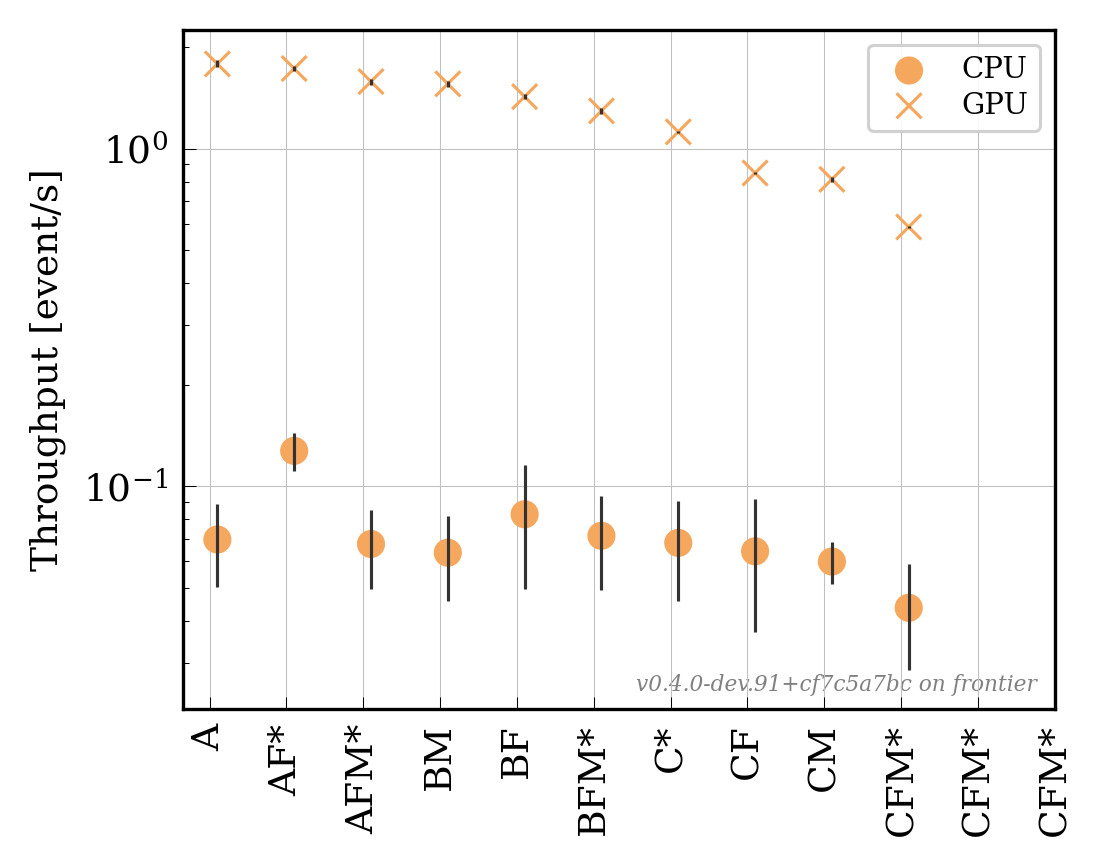

In [36]:
(fig, ax) = plt.subplots()
analyze.plot_event_rate(ax, frontier)
ax.legend()

# Occupancy

In [37]:
BYTES_PER_REG = 4 # 32-bit registers

def load_kernels(results, problem, geo):
    return results.load_results((problem, geo, 'gpu'), 0)['system']['kernels']

def kernel_stats_dataframe(kernel_stats):
    values = []
    index = []
    for (instance, kernels) in kernel_stats.items():
        arch, _, geo = instance.partition('/')
        for (ki, stats) in enumerate(kernels):
            stats.pop('stack_size', None) # Unavailable with HIP
            row = list(stats.values())
            row.append(ki)
            values.append(row)
            name = stats['name']
            if name == "extend-from-secondaries":
                # Fixup duplicate name
                name = f"{name}-{ki}"
            index.append((arch, geo, name))
    index=pd.MultiIndex.from_tuples(index, names=('arch', 'geo', 'name'))
    columns = pd.Index(list(stats.keys()) + ['kernel_index'])
    result = pd.DataFrame(values, index=index, columns=columns)
    del result['name']
    del result['print_buffer_size']
    result['register_mem'] = result['num_regs'] * BYTES_PER_REG
    return result

In [38]:
def plot_kernel_mem(ax, ksdf, colors, labels):
    labels = ['local_mem', 'register_mem']
    y = np.arange(len(labels))
    width = .9 / len(multimem)
    ynudge = np.linspace(-0.34, 0.34, len(multimem))
    
    for (i, (k, mem)) in enumerate(multimem.items()):
        values = np.array(list(mem.values()), dtype=dtype)

        ax.barh(y + ynudge[i], values['register'], width,
                color=colors[k], label=f'{pretty_labels[k]}')
        ax.barh(y + ynudge[i], values['local'], width, left=values['register'],
                color=colors[k + '.spill'])#, label=f'Local spill ({pretty_labels[k]})')

    ax.invert_yaxis();
    ax.set_xlabel('Memory [B]')
    ax.set_yticks(y, labels)
    leg = ax.legend()
    leg.set_title("Register usage (light)\nLocal spill (dark)")
    leg.get_title().set_fontsize('x-small')

In [39]:
kernel_stats = {
    'cuda/vecgeom': load_kernels(summit, 'testem3-flat+field+msc', 'vecgeom'),
    'cuda/orange': load_kernels(summit, 'testem3-flat+field+msc', 'orange'),
    'hip/orange': load_kernels(crusher, 'testem3-flat+field+msc', 'orange'),
}
pretty_labels = {
    'cuda/vecgeom': 'NVIDIA V100 (VecGeom)',
    'cuda/orange': 'NVIDIA V100 (ORANGE)',
    'hip/orange': 'AMD MI250 (ORANGE)',
}
colors = {
    'cuda/vecgeom': (191, 40, 96),
    'cuda/vecgeom.spill': (107, 76, 88),
    'cuda/orange': (153, 168, 50),
    'cuda/orange.spill': (106, 112, 67),
    'hip/orange': (57, 140, 173),
    'hip/orange.spill': (78, 101, 110),
}
colors = {k: np.array(v, dtype=float) / 255 for k, v in colors.items()}

In [40]:
ksdf = kernel_stats_dataframe(kernel_stats)

In [41]:
with open("kernel-occupancy.md", "w") as f:
    analyze.dump_markdown(
        f,
        list(ksdf.index.names) + ['local', 'register', 'occupancy'],
        np.concatenate([
            np.array([list(v) for v in ksdf.index]).T,
            [
                ksdf['local_mem'].apply("{:d}".format),
                ksdf['register_mem'].apply("{:d}".format),
                ksdf['occupancy'].apply("{:.03f}".format)
            ],
        ], axis=0).T,
        alignment="<<<>>>"
    )

In [42]:
labels = {
    'cuda/vecgeom': 'NVIDIA V100 (VecGeom)',
    'cuda/orange': 'NVIDIA V100 (ORANGE)',
    'hip/orange': 'AMD MI250 (ORANGE)',
}
markers = {
    'cuda/vecgeom': '.',
    'cuda/orange': '+',
    'hip/orange': 'x',
}

(fig, ax) = plt.subplots()
for key, ks in ksdf.unstack('name').iterrows():
    k = '/'.join(key)
    ks = ks.unstack(level=0)
    s = ax.scatter(ks['register_mem'], ks['local_mem'],
               c=ks['kernel_index'],
               marker=markers[k], label=labels[k])
ax.set_xlabel('Register usage [B]')
ax.set_ylabel('Memory spill [B]')
ax.legend()
cb = fig.colorbar(s)

plt.tight_layout()
#fig.savefig('plots/reg-vs-spill.png')
fig.savefig('plots/reg-vs-spill.pdf', transparent=True)
plt.close()

In [43]:
(fig, ax) = plt.subplots()
for key, ks in ksdf.unstack('name').iterrows():
    k = '/'.join(key)
    ks = ks.unstack(level=0)
    tot_mem = ks['register_mem'] + ks['local_mem']
    s = ax.scatter(ks['occupancy'], tot_mem,
               c=ks['kernel_index'],
               marker=markers[k], label=labels[k])
#ax.set_xlim(-0.05, 1.05)
ax.set_xlabel('Occupancy')
ax.set_ylabel('Register + spill [B]')
ax.legend()
cb = fig.colorbar(s)

plt.tight_layout()
fig.savefig('plots/occupancy-vs-mem.png')
fig.savefig('plots/occupancy-vs-mem.pdf', transparent=True)
plt.close()

In [44]:
(fig, ax) = plt.subplots()
for key, ks in ksdf.unstack('name').iterrows():
    k = '/'.join(key)
    ks = ks.unstack(level=0)
    s = ax.scatter(ks['occupancy'], ks['local_mem'],
               c=ks['kernel_index'],
               marker=markers[k], label=labels[k])
#ax.set_xlim(-0.05, 1.05)
ax.set_xlabel('Occupancy')
ax.set_ylabel('Local memory spill [B]')
ax.legend()
cb = fig.colorbar(s)

plt.tight_layout()
#fig.savefig('plots/occupancy-vs-spill.png')
fig.savefig('plots/occupancy-vs-spill.pdf', transparent=True)
plt.close()

In [45]:
ksdf[ksdf['local_mem'] > 64]

const_mem    heap_size  \
arch geo     name                                                       
cuda vecgeom scat-rayleigh                         20776      8388608   
     orange  initialize-tracks                         0      8388608   
             along-step-uniform-msc-propagate          0      8388608   
             photoel-livermore                         0      8388608   
             scat-rayleigh                             0      8388608   
             geo-boundary                              0      8388608   
hip  orange  initialize-tracks                         0  68702699520   
             geo-boundary                              0  68702699520   

                                               local_mem  max_blocks_per_cu  \
arch geo     name                                                             
cuda vecgeom scat-rayleigh                           104                  4   
     orange  initialize-tracks                       112                  4   
             along-step-uniform-msc-propagate        240                  2   
             photoel-livermore                        80                  3   
             scat-rayleigh                           104                  4   
             geo-boundary                            176                  4   
hip  orange  initialize-tracks                       120                  5   
             geo-boundary                            304                  5   

                                               max_threads_per_block  \
arch geo     name                                                      
cuda vecgeom scat-rayleigh                                       256   
     orange  initialize-tracks                                   256   
             along-step-uniform-msc-propagate                    256   
             photoel-livermore                                   256   
             scat-rayleigh                                       256   
             geo-boundary                                        256   
hip  orange  initialize-tracks                                   256   
             geo-boundary                                        256   

                                               max_warps_per_eu  num_regs  \
arch geo     name                                                           
cuda vecgeom scat-rayleigh                                   32        64   
     orange  initialize-tracks                               32        64   
             along-step-uniform-msc-propagate                16       128   
             photoel-livermore                               24        68   
             scat-rayleigh                                   32        63   
             geo-boundary                                    32        64   
hip  orange  initialize-tracks                                5        90   
             geo-boundary                                     5        92   

                                               occupancy  threads_per_block  \
arch geo     name                                                             
cuda vecgeom scat-rayleigh                         0.500                256   
     orange  initialize-tracks                     0.500                256   
             along-step-uniform-msc-propagate      0.250                256   
             photoel-livermore                     0.375                256   
             scat-rayleigh                         0.500                256   
             geo-boundary                          0.500                256   
hip  orange  initialize-tracks                     0.625                256   
             geo-boundary                          0.625                256   

                                               kernel_index  register_mem  
arch geo     name                                                          
cuda vecgeom scat-rayleigh                               17           256  
     orange  i

In [46]:
!open .